In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import concatenate
from keras import models

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading

First of all we need to obtain the train, validation and test set. 

In [ ]:
train_ds, val_ds, test_ds = load_data_splits()

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

In [ ]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = 25000 # max size of vocabulary

vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               output_sequence_length = MAX_LENGTH,
                               pad_to_max_tokens=True,
                               max_tokens = MAX_WORDS,
                               ngrams=None)

In [ ]:
vectorizer.adapt(x_train)

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array([[s] for s in y_train])
y_val = np.array([[s] for s in y_val])
y_test = np.array([[s] for s in y_test])

In [ ]:
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
x_test = tf.convert_to_tensor(x_test)

y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

Now we need to load the embedding matrixs pretrained word embedding from spaCy and our custom word embedding.

In [ ]:
embedding_matrix_spacy = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_spacy")
embedding_matrix_custom = loadObject(EMBEDDINGS_PATH + "/embedding_matrix_customed")

# CNN trained with Spacy embeddings



The properties of Convolutional Neural Networks are the most suitable architecture to handle and analyze images but we can also exploit them to extract knowledge from text data as well.


In [ ]:
NUM_CLASSES = len(CLASSES)
NUM_EPOCHS = 40

num_tokens = embedding_matrix_spacy.shape[0]
embedding_dim = embedding_matrix_spacy.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_spacy),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(10, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(10, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(10, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(30, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base")
model.summary()


Model: "CNN_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 350, 300)     8084700     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 348, 10)      9010        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 347, 10)      12010       ['embedding[0][0]']              
                                                                                           

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.9258 - accuracy: 0.3371
Epoch 1: val_loss improved from inf to 1.27755, saving model to model/CNN_base.h5
109/109 [==============================] - 168s 2s/step - loss: 1.9258 - accuracy: 0.3371 - val_loss: 1.2776 - val_accuracy: 0.5622
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 1.3737 - accuracy: 0.4810
Epoch 2: val_loss improved from 1.27755 to 1.09143, saving model to model/CNN_base.h5
109/109 [==============================] - 166s 2s/step - loss: 1.3737 - accuracy: 0.4810 - val_loss: 1.0914 - val_accuracy: 0.6268
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 1.2304 - accuracy: 0.5392
Epoch 3: val_loss improved from 1.09143 to 0.99029, saving model to model/CNN_base.h5
109/109 [==============================] - 165s 2s/step - loss: 1.2304 - accuracy: 0.5392 - val_loss: 0.9903 - val_accuracy: 0.6698
Epoch 4/40
109/109 [==============================] - ETA: 0s 

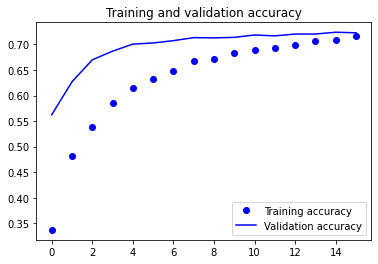

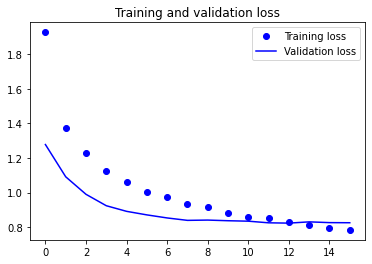

In [ ]:
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 20s 77ms/step - loss: 0.5958 - accuracy: 0.7931
Loss on test set: 0.5958499312400818
Accuracy on test set: 0.7930622100830078
                     precision    recall  f1-score   support

                age     0.9372    0.9474    0.9423      1560
          ethnicity     0.9463    0.9318    0.9390      1570
             gender     0.8399    0.7793    0.8085      1441
           religion     0.9332    0.9338    0.9335      1585
other_cyberbullying     0.4087    0.3563    0.3807       974
  not_cyberbullying     0.5044    0.6008    0.5484      1230

           accuracy                         0.7931      8360
          macro avg     0.7616    0.7582    0.7587      8360
       weighted avg     0.7961    0.7931    0.7936      8360



262/262 [==============================] - 16s 59ms/step


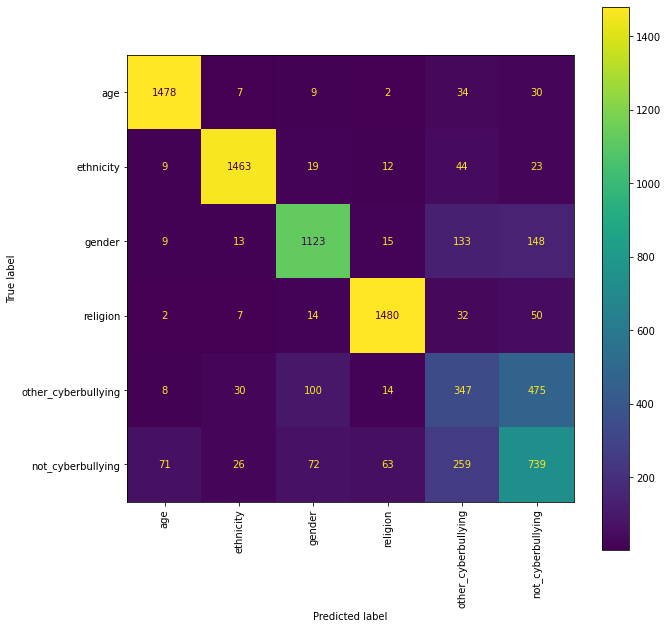

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

# CNN Base trained Custom embeddings

## Conv1D 10, 30 Dense Neurons


In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(10, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(10, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(10, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(30, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base_custom_emb")
model.summary()


Model: "CNN_base_custom_emb"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 350, 50)      1347450     ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 348, 10)      1510        ['embedding_3[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 347, 10)      2010        ['embedding_3[0][0]']            
                                                                                

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5164
Epoch 1: val_loss improved from inf to 1.05218, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 31s 280ms/step - loss: 1.3794 - accuracy: 0.5164 - val_loss: 1.0522 - val_accuracy: 0.6882
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.6753
Epoch 2: val_loss improved from 1.05218 to 0.86042, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 30s 279ms/step - loss: 0.9748 - accuracy: 0.6753 - val_loss: 0.8604 - val_accuracy: 0.7183
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.7222
Epoch 3: val_loss improved from 0.86042 to 0.81210, saving model to model/CNN_base_custom_emb.h5
109/109 [==============================] - 30s 278ms/step - loss: 0.8404 - accuracy: 0.7222 - val_loss: 0.8121 - val_accuracy: 0.7303
Epoch 4/40
109/109 [===

INFO:tensorflow:Assets written to: ram://71dacaaf-8462-43aa-bf3e-2b834c11b7ed/assets


In [ ]:
model.load_weights(MODELS_PATH + "/CNN_base_custom_emb/CNN_base_custom_emb.h5")
history = loadObject(MODELS_PATH + "/CNN_base_custom_emb/history")

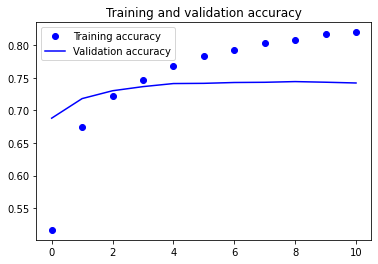

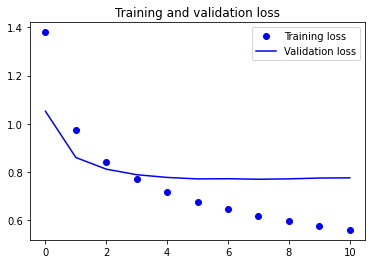

In [ ]:
plot_accuracy_and_loss_history(history) 

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 5s 19ms/step - loss: 0.5292 - accuracy: 0.8163
Loss on test set: 0.5292434692382812
Accuracy on test set: 0.8162679672241211
                     precision    recall  f1-score   support

                age     0.9154    0.9288    0.9220      1560
          ethnicity     0.9567    0.9433    0.9500      1570
             gender     0.8664    0.8598    0.8631      1441
           religion     0.9201    0.9230    0.9216      1585
other_cyberbullying     0.5021    0.4877    0.4948       974
  not_cyberbullying     0.5677    0.5829    0.5752      1230

           accuracy                         0.8163      8360
          macro avg     0.7881    0.7876    0.7878      8360
       weighted avg     0.8163    0.8163    0.8162      8360



262/262 [==============================] - 3s 12ms/step


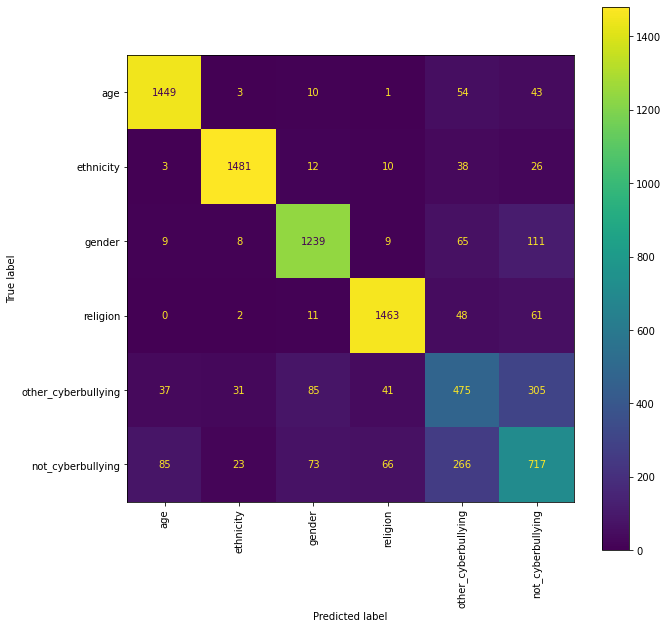

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## Conv 1D 20, 45 Dense Neurons

In [ ]:
num_tokens = embedding_matrix_custom.shape[0]
embedding_dim = embedding_matrix_custom.shape[1]

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(20, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(20, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(20, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(45, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base_custom_emb_20")
model.summary()


Model: "CNN_base_custom_emb_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 350, 50)      1347450     ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 348, 20)      3020        ['embedding_3[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 347, 20)      4020        ['embedding_3[0][0]']            
                                                                             

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.5798
Epoch 1: val_loss improved from inf to 0.87233, saving model to model/CNN_base_custom_emb_20.h5
109/109 [==============================] - 22s 190ms/step - loss: 1.2195 - accuracy: 0.5798 - val_loss: 0.8723 - val_accuracy: 0.7136
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.7540
Epoch 2: val_loss improved from 0.87233 to 0.78342, saving model to model/CNN_base_custom_emb_20.h5
109/109 [==============================] - 21s 189ms/step - loss: 0.7590 - accuracy: 0.7540 - val_loss: 0.7834 - val_accuracy: 0.7310
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.7939
Epoch 3: val_loss improved from 0.78342 to 0.77362, saving model to model/CNN_base_custom_emb_20.h5
109/109 [==============================] - 20s 185ms/step - loss: 0.6476 - accuracy: 0.7939 - val_loss: 0.7736 - val_accuracy: 0.7370
Epoch 4/40
109

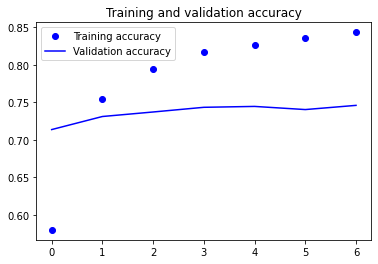

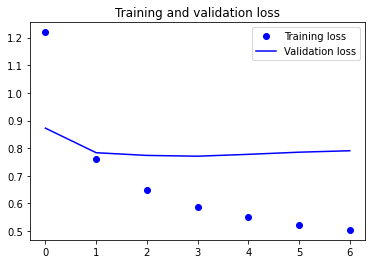

In [ ]:
plot_accuracy_and_loss_history(history) 

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 2s 8ms/step - loss: 0.5249 - accuracy: 0.8145
Loss on test set: 0.5248731374740601
Accuracy on test set: 0.8144736886024475
                     precision    recall  f1-score   support

                age     0.9079    0.9224    0.9151      1560
          ethnicity     0.9331    0.9503    0.9416      1570
             gender     0.8641    0.8557    0.8598      1441
           religion     0.8945    0.9413    0.9173      1585
other_cyberbullying     0.5092    0.4815    0.4950       974
  not_cyberbullying     0.5897    0.5561    0.5724      1230

           accuracy                         0.8145      8360
          macro avg     0.7831    0.7846    0.7835      8360
       weighted avg     0.8093    0.8145    0.8116      8360



262/262 [==============================] - 2s 8ms/step


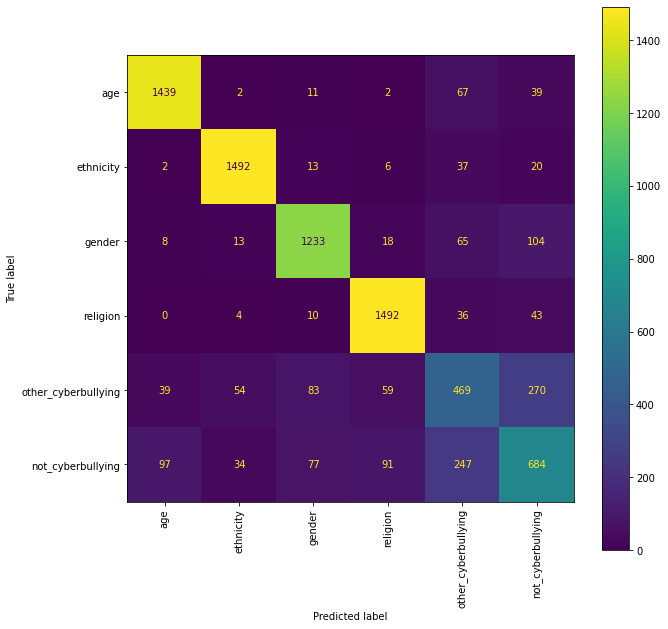

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## Conv 1D 50, 45 Dense Neurons


In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_custom),
    input_length = MAX_LENGTH,
    trainable=False,
)

int_sequences_input = keras.Input(shape=(MAX_LENGTH))
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(50, 3, activation="relu")(embedded_sequences)
y = layers.Conv1D(50, 4, activation="relu")(embedded_sequences)
z = layers.Conv1D(50, 5, activation="relu")(embedded_sequences)
px = layers.GlobalMaxPooling1D()(x)
py = layers.GlobalMaxPooling1D()(y)
pz = layers.GlobalMaxPooling1D()(z)

concat = concatenate([px,py,pz])
x = layers.Dense(45, activation="relu")(concat)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds, name="CNN_base_custom_emb_20")
model.summary()


Model: "CNN_base_custom_emb_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 350)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 350, 50)      1347450     ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 348, 50)      7550        ['embedding_4[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 347, 50)      10050       ['embedding_4[0][0]']            
                                                                             

In [ ]:
model = compile_model(model, loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, NUM_EPOCHS, patience = 3, monitor='val_loss')

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.0264 - accuracy: 0.6624
Epoch 1: val_loss improved from inf to 0.81989, saving model to model/CNN_base_custom_emb_20.h5
109/109 [==============================] - 35s 314ms/step - loss: 1.0264 - accuracy: 0.6624 - val_loss: 0.8199 - val_accuracy: 0.7246
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7844
Epoch 2: val_loss improved from 0.81989 to 0.79006, saving model to model/CNN_base_custom_emb_20.h5
109/109 [==============================] - 33s 306ms/step - loss: 0.6705 - accuracy: 0.7844 - val_loss: 0.7901 - val_accuracy: 0.7345
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.8190
Epoch 3: val_loss did not improve from 0.79006
109/109 [==============================] - 32s 297ms/step - loss: 0.5820 - accuracy: 0.8190 - val_loss: 0.7990 - val_accuracy: 0.7392
Epoch 4/40
109/109 [==============================] - ETA: 0s - los

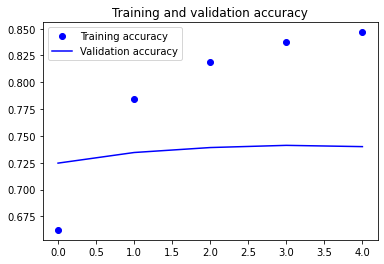

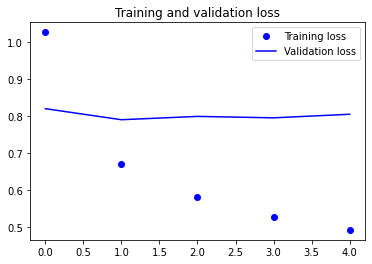

In [ ]:
plot_accuracy_and_loss_history(history) 

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 4s 13ms/step - loss: 0.5578 - accuracy: 0.8087
Loss on test set: 0.5578274726867676
Accuracy on test set: 0.8087320327758789
                     precision    recall  f1-score   support

                age     0.8749    0.9372    0.9050      1560
          ethnicity     0.9313    0.9503    0.9407      1570
             gender     0.8245    0.8772    0.8500      1441
           religion     0.8673    0.9483    0.9060      1585
other_cyberbullying     0.5312    0.4014    0.4573       974
  not_cyberbullying     0.5982    0.5276    0.5607      1230

           accuracy                         0.8087      8360
          macro avg     0.7712    0.7737    0.7700      8360
       weighted avg     0.7946    0.8087    0.7996      8360



262/262 [==============================] - 3s 13ms/step


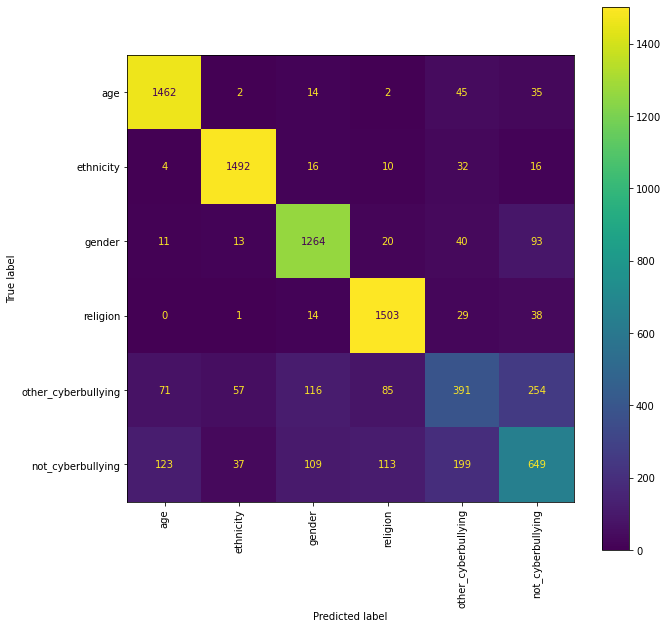

In [ ]:
plot_confusionmatrix(model, x_test, y_test)